# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2022 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
from EPNM.models.model import Economic_Model
from EPNM.data.parameters import get_model_parameters
from EPNM.data.utils import get_sector_labels, get_sector_names, aggregate_simulation, get_sectoral_conversion_matrix
from EPNM.models.TDPF import household_demand_shock, compute_income_expectations
from EPNM.models.draw_functions import draw_function as draw_function
from EPNM.data.calibration_data import get_NAI_value_added, get_revenue_survey, get_employment_survey, get_synthetic_GDP, get_B2B_demand

## Setup model

In [5]:
from EPNM.models.utils import initialize_model
params, model = initialize_model(shocks='alleman', prodfunc='half_critical')

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])


In [6]:
# Extract key dates
t_start_lockdown_1 = params['t_start_lockdown_1']
t_end_lockdown_1 = params['t_end_lockdown_1']
t_start_lockdown_2 = params['t_start_lockdown_2']
t_end_lockdown_2 = params['t_end_lockdown_2']
t_start_final_relax = params['t_start_final_relax']

In [7]:
#############################
## Load samples dictionary ##
#############################

import json
identifier= 'test'
date = '2023-03-23'
# Path where MCMC samples should be saved
samples_path = f'../../data/EPNM/interim/calibrations/'
# Load raw samples dict
samples_dict = {}
#samples_dict = json.load(open(samples_path+'national_'+str(identifier) + '_SAMPLES_' + str(date) + '.json')) # Why national

### WSSE vs Production function vs $\tau$

In [8]:
start_calibration = '2020-03-01'
end_calibration = '2020-07-01'

from pySODM.optimization.objective_functions import log_posterior_probability, ll_gaussian

import xarray as xr
def aggregate_NACE21(simulation_in):
    """ A function to convert a simulation of the economic IO model on the NACE64 level to the NACE21 level
    
    Input
    =====
    simulation_in: xarray.DataArray
        Simulation result (NACE64 level). Obtained from a pySODM xarray.Dataset simulation result by using: xarray.Dataset[state_name]
    
    Output
    ======
    simulation_out: xarray.DataArray
        Simulation result (NACE21 level)
    """

    simulation_out = xr.DataArray(np.matmul(np.matmul(simulation_in.values, np.transpose(get_sectoral_conversion_matrix('NACE64_NACE38'))), np.transpose(get_sectoral_conversion_matrix('NACE38_NACE21'))),
                                    dims = ['date', 'NACE21'],
                                    coords = dict(NACE21=(['NACE21'], get_sector_labels('NACE21')),
                                    date=simulation_in.coords['date']))
    return simulation_out

def aggregate_dummy(simulation_in):
    """
    Does nothing
    """
    return simulation_in

# Get data
data_employment = get_employment_survey(relative=False)
data_revenue = get_revenue_survey(relative=False)
data_GDP = get_synthetic_GDP(relative=False)
data_B2B_demand = get_B2B_demand(relative=False)

# Define dataset
data = [
        # NACE 64 sectoral data
        data_employment.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        data_revenue.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        data_GDP.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        # National data
        data_employment.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        data_revenue.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        data_GDP.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        # NACE 21 B2B Demand data
        data_B2B_demand.drop('U', level='NACE21', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        ]

# Assign a higher weight to the national data
weights = [
           1/len(data_employment.index.get_level_values('NACE64').unique())/len(data_employment.index.get_level_values('date').unique()),
           1/len(data_revenue.index.get_level_values('NACE64').unique())/len(data_revenue.index.get_level_values('date').unique()),
           1/len(data_GDP.index.get_level_values('NACE64').unique())/len(data_GDP.index.get_level_values('date').unique()),
           1/len(data_employment.index.get_level_values('date').unique()),
           1/len(data_revenue.index.get_level_values('date').unique()),
           1/len(data_GDP.index.get_level_values('date').unique()),
           1/len(data_B2B_demand.index.get_level_values('NACE21').unique())/len(data_B2B_demand.index.get_level_values('date').unique()),
           ]
# States to calibrate
states = ["l", "x", "x", "l", "x", "x", "O"]  
# Log likelihood functions and arguments
log_likelihood_fnc = [ll_gaussian, ll_gaussian,ll_gaussian, ll_gaussian,ll_gaussian, ll_gaussian, ll_gaussian]
sigma = 0.05
log_likelihood_fnc_args = [
        sigma*data_employment.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        sigma*data_revenue.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        sigma*data_GDP.drop('BE', level='NACE64', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        sigma*data_employment.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        sigma*data_revenue.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        sigma*data_GDP.loc[slice(start_calibration, end_calibration), 'BE'].reset_index().drop('NACE64', axis=1).set_index('date').squeeze(),
        sigma*data_B2B_demand.drop('U', level='NACE21', axis=0, inplace=False).loc[slice(start_calibration, end_calibration), slice(None)],
        ]
# Aggregation functions
aggregation_functions = [
        aggregate_dummy,
        aggregate_dummy,
        aggregate_dummy,
        aggregate_dummy,
        aggregate_dummy,
        aggregate_dummy,
        aggregate_NACE21,
        ]

# Consumer demand/Exogeneous demand shock during summer of 2020
pars = ['tau',]
bounds=((1,100),)

objective_function = log_posterior_probability(model, pars, bounds, data, states, log_likelihood_fnc, log_likelihood_fnc_args, aggregation_function=aggregation_functions, weights=weights)

In [ ]:
tau_lst = np.linspace(start=1, stop=60, num=20)
prodfunc_lst = ['weakly_critical', 'half_critical', 'strongly_critical']

WSSE_global = []
for prodfunc in prodfunc_lst:
    print(prodfunc)
    WSSE = []
    # Initialize model
    params, model = initialize_model(shocks='alleman', prodfunc=prodfunc)
    # Initialize WSSE
    objective_function.model = model
    # Compute WSSE vs. tau
    for tau in tau_lst:
        theta = [tau,]
        WSSE.append(objective_function(theta))
    WSSE_global.append(WSSE)

# Convert to relative deviation
WSSE_relative = []
for WSSE in WSSE_global:
    WSSE_relative.append(np.abs(np.array(WSSE))/np.abs(np.array(WSSE_global[-1]))*100)

weakly_critical


/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:128: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:128: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COV

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing me

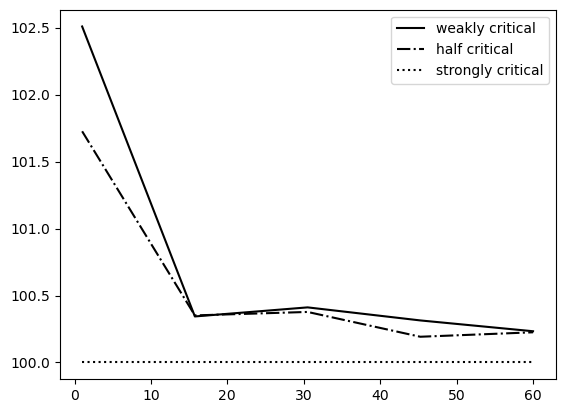

In [11]:
linestyles = ['-', '-.', ':']
labels = ['weakly critical', 'half critical', 'strongly critical']

fig,ax=plt.subplots()
for i,WSSE in enumerate(WSSE_relative):
    # Add to plot
    ax.plot(tau_lst, WSSE, color='black', linestyle = linestyles[i], label=labels[i])
ax.legend()
plt.show()
plt.close()

## Simulate

In [7]:
data_employment = get_employment_survey()
data_revenue = get_revenue_survey()
data_GDP = get_synthetic_GDP()
data_B2B_demand = get_B2B_demand()
data_NAI = get_NAI_value_added(NACE10=False, relative=True)
# Start- and enddate
start_date = data_GDP.index.get_level_values('date').unique().min()
end_date = data_GDP.index.get_level_values('date').unique().max()

In [8]:
out=model.sim([start_date, end_date], draw_function=draw_function, samples=samples_dict, N=2*18, processes=18, method='RK45', rtol=5e-5)
simtime = out['date'].values

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.n

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: All-NaN slice encountered
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:142: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(np.array([cond_1[i], cond_2[i]]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: All-NaN slice encountered
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:142: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(np.array([cond_1[i], cond_2[i]]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.n

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.n

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: All-NaN slice encountered
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:142: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(np.array([cond_1[i], cond_2[i]]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/Documents/UGent/projects/Corona/code

## Illustrate household demand shock

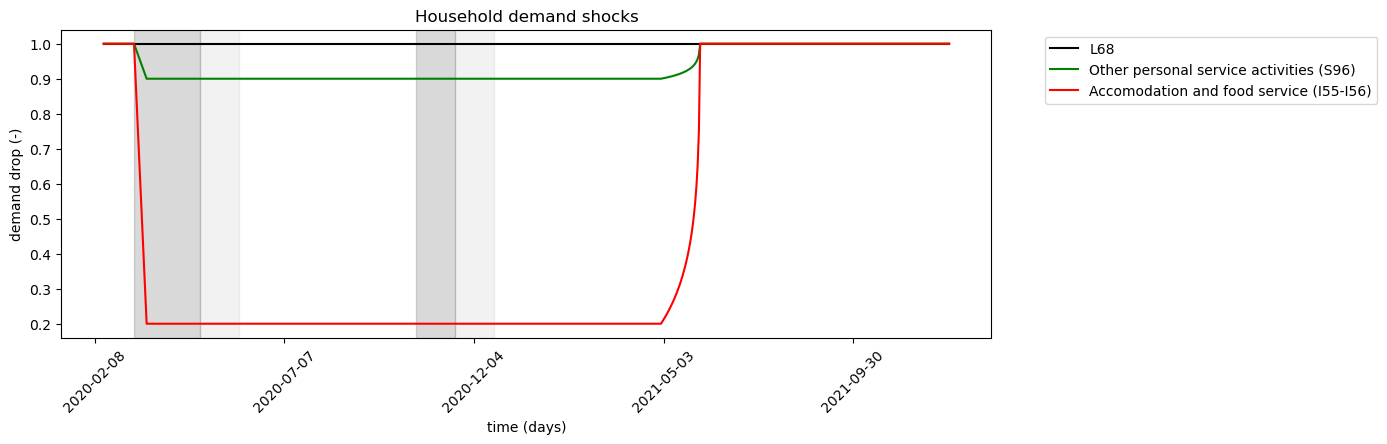

In [9]:
sector = 'L68'

for idx,time in enumerate(simtime):
    epsilon_t = 1-household_demand_shock(time, {}, params['epsilon_D'], params['l1'], params['l2'], params['t_start_lockdown_1'], params['t_end_lockdown_1'], params['t_start_lockdown_2'], params['t_end_lockdown_2'], params['t_start_final_relax'], params['c_s'], params['c_s_NACE21'], params['convmat'], params['ratio_c_s'], params['on_site'])
    if idx == 0:
        epsilon = np.expand_dims(epsilon_t,axis=1)
    else:
        epsilon = np.append(epsilon, np.expand_dims(epsilon_t,axis=1), axis=1)
    
fig,ax = plt.subplots(figsize=(12,4))
plottime = 600
# Plot shocks
ax.plot(simtime,epsilon[get_sector_labels('NACE64').index(sector),:],color='black')
ax.plot(simtime,epsilon[-2,:],color='green')
ax.plot(simtime,epsilon[-28,:],color='red')
# Shade lockdown 1
ax.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title('Household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend([sector,'Other personal service activities (S96)','Accomodation and food service (I55-I56)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Illustrate long-term expectation of income

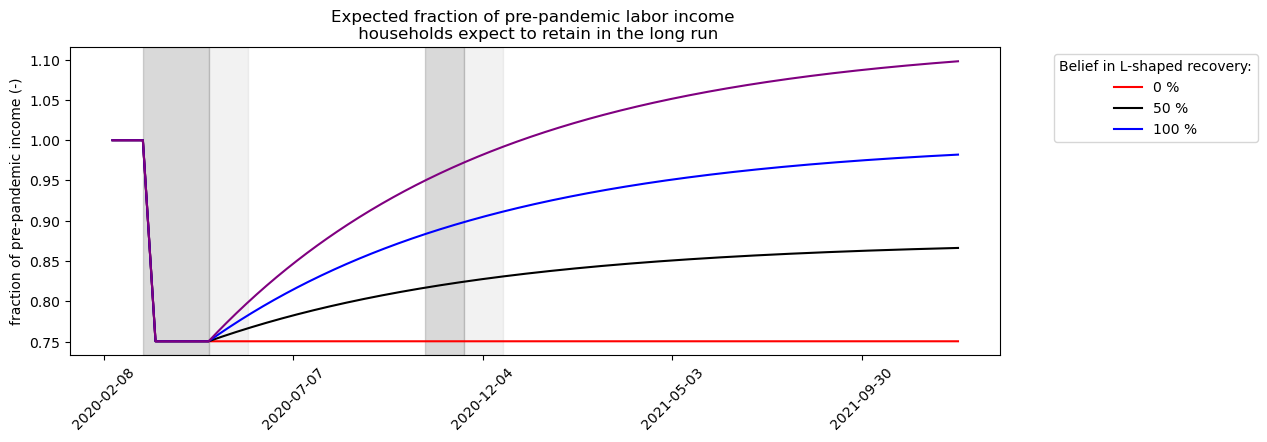

In [10]:
fig,ax = plt.subplots(figsize=(12,4))

color=['red','black','blue', 'purple']
i=0
for L in [0,0.5,1,1.5]:
    zeta=[]
    for time in simtime:
        zeta.append(compute_income_expectations(time, {}, {}, params['l1'], params['t_start_lockdown_1'],params['t_end_lockdown_1'],params['l_0'],params['l_start_lockdown'],params['rho'],L))
    ax.plot(simtime,zeta,color=color[i])
    i=i+1
    
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# Shade lockdown 1
ax.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid(False)
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Simulation results

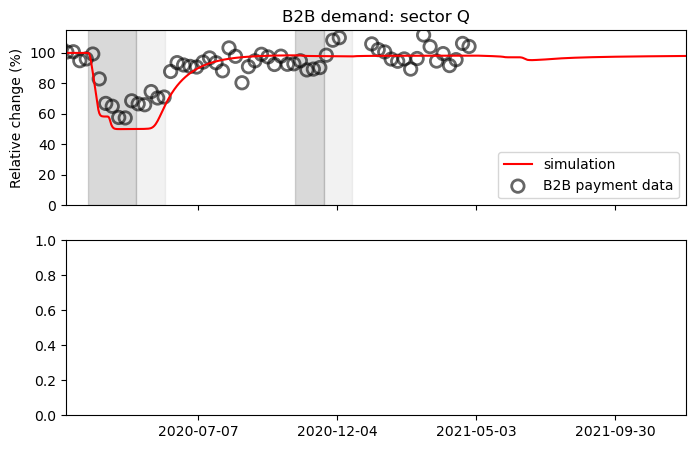

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,5), sharex=True)

sector = 'Q'

ax1.set_title(f'B2B demand: sector {sector}')
ax1.plot(simtime,aggregate_simulation(out['O'].mean(dim='draws'), 'NACE21').sel(NACE21=sector)/aggregate_simulation(out['O'].mean(dim='draws'), 'NACE21').sel(NACE21=sector).isel(date=0)*100,color='red', label='simulation')
copy_df = data_B2B_demand.loc[slice('2017-01-01',None)]
ax1.scatter(copy_df.index.get_level_values('date').unique(), copy_df.loc[slice(None), sector].rolling(window=2).mean(), color='black', alpha=0.6, linestyle='None', facecolors='none', s=80, linewidth=2, label='B2B payment data')
ax1.legend()
ax1.set_ylabel('Relative change (%)')
ax1.set_ylim([0,None])
ax1.set_xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
ax1.grid(False)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Shade lockdown 1
ax1.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax1.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

# sector_NACE64 = 'P85'
# ax2.set_title(f'Gross output: sector {sector}')
# ax2.plot(simtime,aggregate_simulation(out['x'].mean(dim='draws'), 'NACE21').sel(NACE21=sector)/aggregate_simulation(out['x'].mean(dim='draws'), 'NACE21').sel(NACE21=sector).isel(date=0)*100,color='red', label='simulation')
# ax2.scatter(data_revenue.loc[slice(None), sector_NACE64].index.get_level_values('date').unique(), data_revenue.loc[slice(None), sector_NACE64]*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='revenue survey NBB')
# ax2.legend()
# ax2.set_ylim([0,None])
# ax2.grid(False)
# ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
# for tick in ax2.get_xticklabels():
#     tick.set_rotation(45)
    
# # Shade lockdown 1
# ax2.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
# ax2.axvspan(xmin=t_end_lockdown_1, xmax=t_end_relax_1, color='black', alpha=0.05)
# # Shade lockdown 2
# ax2.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
# ax2.axvspan(xmin=t_end_lockdown_2, xmax=t_end_relax_2, color='black', alpha=0.05)

plt.show()
plt.close()

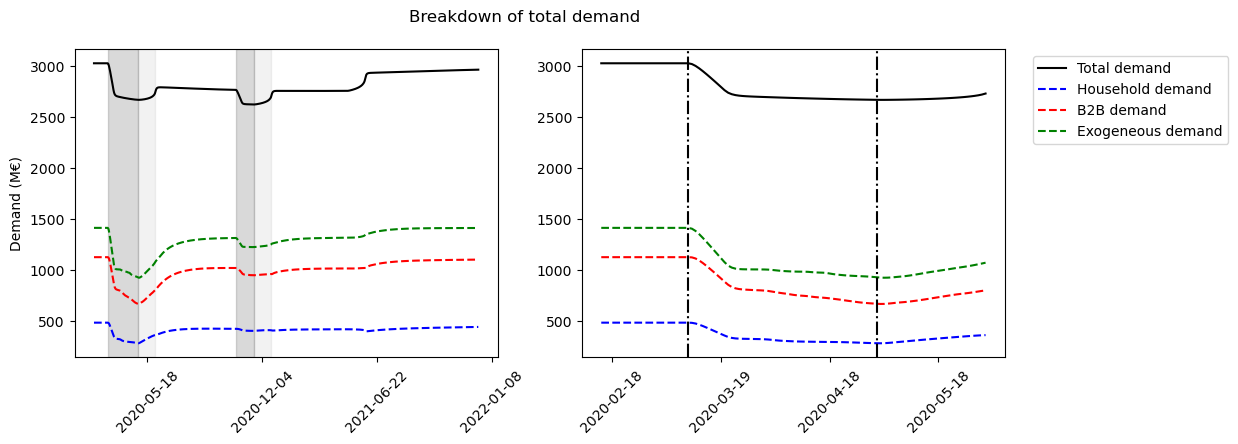

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')
# Total demand
ax1.plot(simtime,out['d'].sum(dim='NACE64').mean(dim='draws'),color='black')
ax1.plot(simtime,out['c'].sum(dim='NACE64').mean(dim='draws'),color='blue',ls='--')
ax1.plot(simtime,out['O'].sum(dim='NACE64').mean(dim='draws'),color='red',ls='--')
ax1.plot(simtime,out['f'].sum(dim='NACE64').mean(dim='draws'),color='green',ls='--')
# Shade lockdown 1
ax1.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax1.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),out['d'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),color='black')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),out['c'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),out['O'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),out['f'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, t_end_lockdown_1+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown_1,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown_1,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

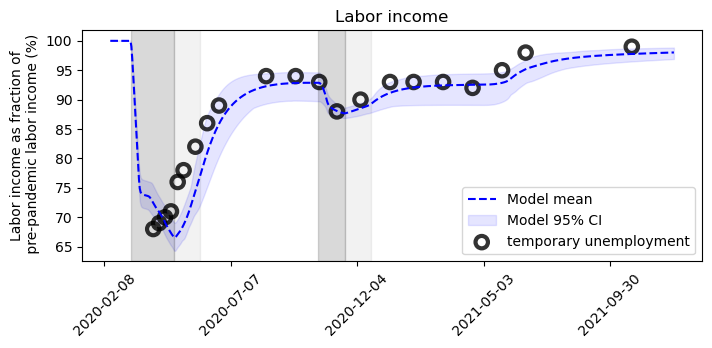

In [13]:
fig,ax=plt.subplots(figsize=(8,3))

ax.plot(simtime, (out['l'].sum(dim='NACE64').mean(dim='draws')/np.sum(params['l_0'],axis=0)*100), linestyle= '--', color='blue', label='Model mean')
ax.fill_between(simtime,(out['l'].sum(dim='NACE64').quantile(dim='draws', q=0.025)/np.sum(params['l_0'],axis=0)*100), 
                (out['l'].sum(dim='NACE64').quantile(dim='draws', q=0.975)/np.sum(params['l_0'],axis=0)*100), color='blue', alpha = 0.10, label='Model 95% CI')
ax.scatter(data_employment.loc[slice(None,end_date), 'BE'].index.get_level_values('date').unique(), data_employment.loc[slice(None,end_date), 'BE']*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='temporary unemployment')
# Shade lockdown 1
ax.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax.legend()
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid(False)
plt.show()

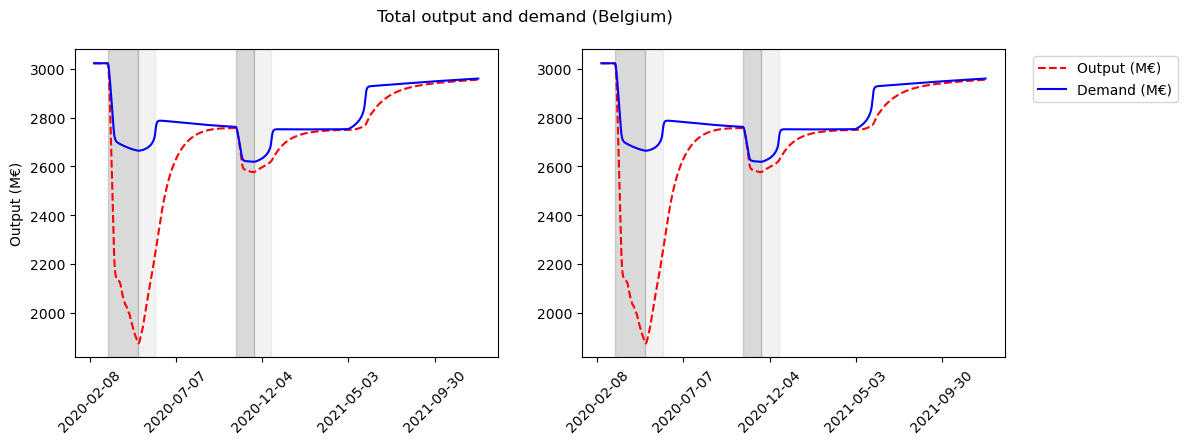

In [14]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(12,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(simtime,out['x'].sum(dim='NACE64').mean(dim='draws'),color='red',ls='--')
ax1.plot(simtime,out['d'].sum(dim='NACE64').mean(dim='draws'),color='blue')
# Shade lockdown 1
ax1.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax1.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax1.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, end_date)),out['x'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, end_date)),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, end_date)),out['d'].sum(dim='NACE64').mean(dim='draws').sel(date=slice(start_date, end_date)),color='blue')

# Shade lockdown 1
ax2.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax2.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax2.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax2.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

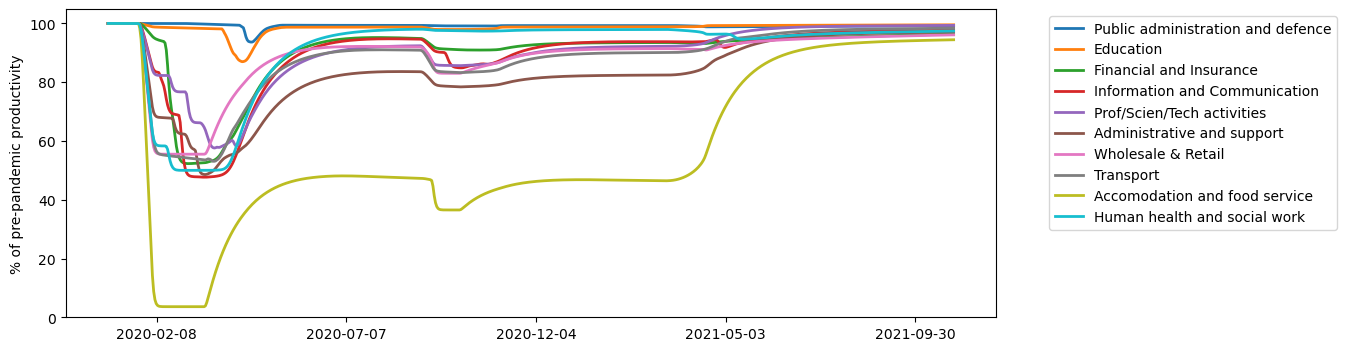

In [15]:
classification = 'NACE21'
sectors = ['O', 'P', 'K', 'J', 'M', 'N', 'G', 'H', 'I', 'Q']
sectors_name = ['Public administration and defence', 'Education', 'Financial and Insurance',
                'Information and Communication', 'Prof/Scien/Tech activities', 'Administrative and support',
                'Wholesale & Retail', 'Transport', 'Accomodation and food service', 'Human health and social work']
x = aggregate_simulation(out['x'].mean(dim='draws'), classification)

fig,ax=plt.subplots(figsize=(12,4))
for sector in sectors:
    ax.plot(out['date']-pd.Timedelta(days=45.5),x.sel({classification: sector})/x.sel({classification: sector}).isel(date=0)*100,linewidth=2, alpha=1)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(False)
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(sectors_name,bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0,None])
fig.savefig('x_NACE21.jpg',dpi=400, bbox_inches='tight')
plt.show()
plt.close()

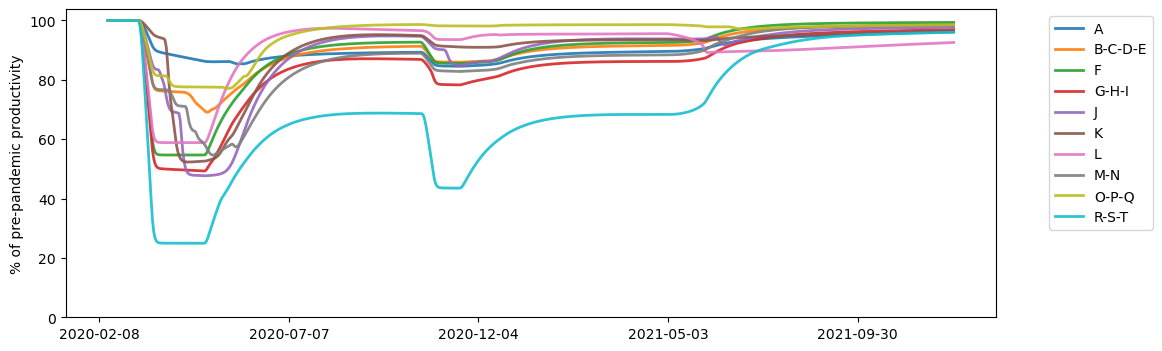

In [16]:
classification = 'NACE10'
x = aggregate_simulation(out['x'].mean(dim='draws'), classification)

fig,ax=plt.subplots(figsize=(12,4))
for sector in x.coords[classification].values:
    ax.plot(simtime,x.sel({classification: sector})/x.sel({classification: sector}).isel(date=0)*100,linewidth=2, alpha=0.9)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(False)
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(x.coords[classification].values,bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0,None])
fig.savefig('x_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')
plt.show()

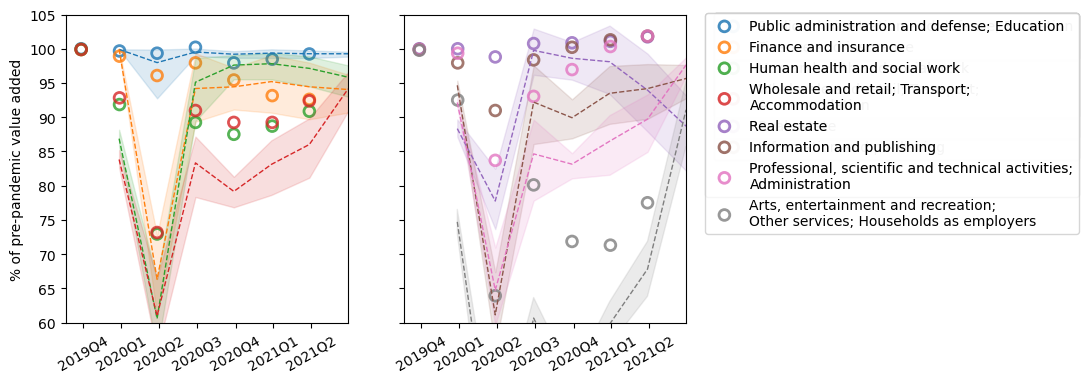

In [17]:
order = ['O-P', 'K', 'Q', 'G-H-I',
         'L', 'J', 'M-N', 'R-S-T']
# Define labels manually
labels = ['Public administration and defense; Education', 'Finance and insurance', 'Human health and social work',
          'Wholesale and retail; Transport;\nAccommodation', 'Real estate', 'Information and publishing',
          'Professional, scientific and technical activities;\nAdministration', 
          'Arts, entertainment and recreation;\nOther services; Households as employers']
# Define colors manually
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf']
# Aggregate to NACE21 and NACE10 (baseline)
x_NACE10_bl = aggregate_simulation(out['x'].mean(dim='draws')-out['O'].mean(dim='draws'), 'NACE10')
x_NACE21_bl = aggregate_simulation(out['x'].mean(dim='draws')-out['O'].mean(dim='draws'), 'NACE21')
x_NACE10_bl_ll = aggregate_simulation(out['x'].quantile(dim='draws', q=0.025)-out['O'].quantile(dim='draws', q=0.025), 'NACE10')
x_NACE21_bl_ll = aggregate_simulation(out['x'].quantile(dim='draws', q=0.025)-out['O'].quantile(dim='draws', q=0.025), 'NACE21')
x_NACE10_bl_ul = aggregate_simulation(out['x'].quantile(dim='draws', q=0.975)-out['O'].quantile(dim='draws', q=0.975), 'NACE10')
x_NACE21_bl_ul = aggregate_simulation(out['x'].quantile(dim='draws', q=0.975)-out['O'].quantile(dim='draws', q=0.975), 'NACE21')
# Resample to quarters
x_NACE10 = x_NACE10_bl.resample(date='Q').mean()
x_NACE21 = x_NACE21_bl.resample(date='Q').mean()
x_NACE10_ll = x_NACE10_bl_ll.resample(date='Q').mean()
x_NACE21_ll = x_NACE21_bl_ll.resample(date='Q').mean()
x_NACE10_ul = x_NACE10_bl_ul.resample(date='Q').mean()
x_NACE21_ul = x_NACE21_bl_ul.resample(date='Q').mean()
# Visualise against NAI added value data
fig,axs=plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,4))

for i,sector in enumerate(order): #enumerate(data_NAI.index.get_level_values('NACE10/NACE21').unique()):
    if i < 4:
        ax = axs[0]
        ax.set_ylabel('% of pre-pandemic value added')
    else:
        ax = axs[1]
        
    if sector == 'O-P':
        ax.plot(x_NACE21.date.values-pd.Timedelta(days=46), (x_NACE21.sel({'NACE21':'O'})+x_NACE21.sel({'NACE21':'P'}))/(x_NACE21_bl.sel({'NACE21': 'O'}).isel(date=0)+x_NACE21_bl.sel({'NACE21': 'P'}).isel(date=0))*100,
                color=colors[i], linestyle='--', linewidth=1, alpha=1)
        ax.fill_between(x_NACE21.date.values-pd.Timedelta(days=46), (x_NACE21_ll.sel({'NACE21':'O'})+x_NACE21_ll.sel({'NACE21':'P'}))/(x_NACE21_bl_ll.sel({'NACE21': 'O'}).isel(date=0)+x_NACE21_bl_ll.sel({'NACE21': 'P'}).isel(date=0))*100,
                        (x_NACE21_ul.sel({'NACE21':'O'})+x_NACE21_ul.sel({'NACE21':'P'}))/(x_NACE21_bl_ul.sel({'NACE21': 'O'}).isel(date=0)+x_NACE21_bl_ul.sel({'NACE21': 'P'}).isel(date=0))*100,
                         color=colors[i], alpha=0.15)
        ax.scatter(data_NAI.index.get_level_values('date').unique(), data_NAI.loc[slice(None), sector],
                   label=labels[i], color=colors[i], alpha=0.8, linestyle='None', facecolors='none', s=60, linewidth=2)
    elif sector == 'Q':
        ax.plot(x_NACE21.date.values-pd.Timedelta(days=46), x_NACE21.sel({'NACE21':'Q'})/x_NACE21_bl.sel({'NACE21':'Q'}).isel(date=0)*100,
                color=colors[i], linestyle='--', linewidth=1, alpha=1)
        ax.fill_between(x_NACE21.date.values-pd.Timedelta(days=46), x_NACE21_ll.sel({'NACE21':'Q'})/x_NACE21_bl_ll.sel({'NACE21':'Q'}).isel(date=0)*100,
                        x_NACE21_ul.sel({'NACE21':'Q'})/x_NACE21_bl_ul.sel({'NACE21':'Q'}).isel(date=0)*100,
                        color=colors[i], alpha=0.15)
        ax.scatter(data_NAI.index.get_level_values('date').unique(), data_NAI.loc[slice(None), sector],
                   label=labels[i], color=colors[i], alpha=0.8, linestyle='None', facecolors='none', s=60, linewidth=2)
    else:
        ax.plot(x_NACE10.date.values-pd.Timedelta(days=46), x_NACE10.sel({'NACE10': sector})/x_NACE10_bl.sel({'NACE10': sector}).isel(date=0)*100,
                color=colors[i], linestyle='--', linewidth=1, alpha=1)
        ax.fill_between(x_NACE10.date.values-pd.Timedelta(days=46), x_NACE10_ll.sel({'NACE10': sector})/x_NACE10_bl_ll.sel({'NACE10': sector}).isel(date=0)*100,
                        x_NACE10_ul.sel({'NACE10': sector})/x_NACE10_bl_ul.sel({'NACE10': sector}).isel(date=0)*100,
                        color=colors[i], alpha=0.15)
        ax.scatter(data_NAI.index.get_level_values('date').unique().values, data_NAI.loc[slice(None), sector],
                   label=labels[i], color=colors[i], alpha=0.8, marker='o', linestyle='None', facecolors='none', s=60, linewidth=2)
        
        # Formatting
        ax.grid(False)
        ax.set_ylim([60,105])
        ax.set_xlim([None, data_NAI.index.get_level_values('date').unique().max()+pd.Timedelta(days=92)])
        # Set custom xlabels
        dates = pd.date_range(start=data_NAI.index.get_level_values('date').unique().min(),
                              end=data_NAI.index.get_level_values('date').unique().max()+pd.Timedelta(days=92),
                              freq='Q') - pd.Timedelta(days=42)
        ax.set_xticks(ticks=dates, labels=['2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2'])
        # Rotate xlabels
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
        fig.legend(bbox_to_anchor=(1.40, 0.9),) 
        
fig.savefig('x_validation_NAI.jpg',dpi=600, bbox_inches='tight')
plt.show()

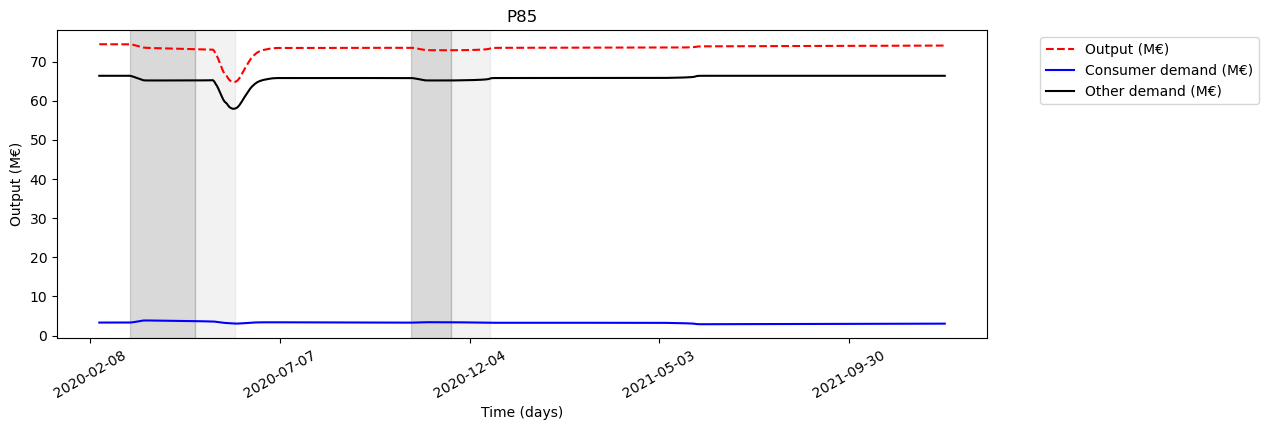

In [18]:
fig,ax=plt.subplots(figsize=(12,4))

sector = 'P85'
idx = get_sector_labels('NACE64').index(sector)
ax.plot(simtime,out['x'].mean(dim='draws')[:,idx],color='red',ls='--', label='Output (M€)')
ax.plot(simtime,out['c'].mean(dim='draws')[:,idx],color='blue', label='Consumer demand (M€)')
ax.plot(simtime,out['f'].mean(dim='draws')[:,idx],color='black', label='Other demand (M€)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Shade lockdown 1
ax.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax.set_title(sector)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.grid(False)
plt.show()

## To labor shock or not to labor shock

In [19]:
model.parameters.update({'l_s_1': np.zeros(63), 'l_s_2': np.zeros(63)})
out_no_labor_shock = model.sim([start_date, end_date], N=18, draw_function=draw_function, processes=18, method='RK45', rtol=5e-5)

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: invalid value encountered in true_divide
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: RuntimeWarning: All-NaN slice encountered
  cond_1[i] = np.nanmin(S_t[critical,i]/A[critical,i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: invalid value encountered in true_divide
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:137: Runtim

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:142: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(np.array([cond_1[i], cond_2[i]]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value encountered in log
  return (1-epsilon_t)*np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p)))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:141: RuntimeWarning: All-NaN slice encountered
  cond_2[i] = np.nanmin(0.5*(np.array(S_t[important,i]/A[important,i]) + x_0[i]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:142: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(np.array([cond_1[i], cond_2[i]]))
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/EPNM/models/model.py:224: RuntimeWarning: invalid value 

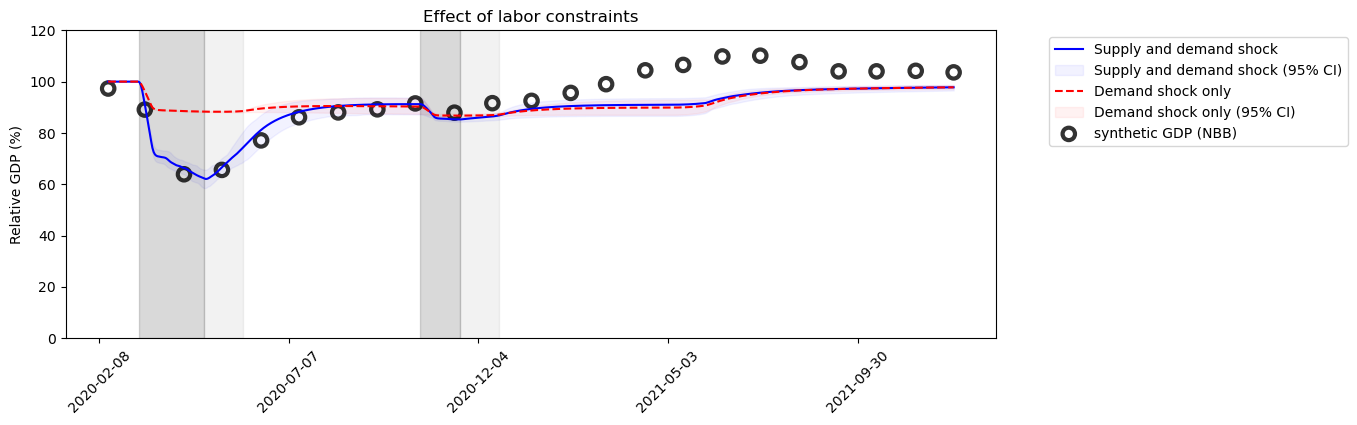

In [20]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(simtime,out['x'].sum(dim='NACE64').mean(dim='draws')/out['x'].sum(dim='NACE64').mean(dim='draws').sel(date=simtime[0])*100,color='blue',label='Supply and demand shock')
ax.fill_between(simtime, out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.025)/out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.025).sel(date=simtime[0])*100,
                out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.975)/out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.975).sel(date=simtime[0])*100,
                color='blue', alpha=0.05, label='Supply and demand shock (95% CI)')

ax.plot(out_no_labor_shock['date'],out_no_labor_shock['x'].sum(dim='NACE64').mean(dim='draws')/out['x'].sum(dim='NACE64').mean(dim='draws').sel(date=simtime[0])*100,color='red',ls='--',label='Demand shock only')
ax.fill_between(simtime, out_no_labor_shock['x'].sum(dim='NACE64').quantile(dim='draws', q=0.025)/out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.025).sel(date=simtime[0])*100,
                out_no_labor_shock['x'].sum(dim='NACE64').quantile(dim='draws', q=0.975)/out['x'].sum(dim='NACE64').quantile(dim='draws', q=0.975).sel(date=simtime[0])*100,
                color='red', alpha=0.05, label='Demand shock only (95% CI)')

ax.scatter(data_GDP.loc[slice(None,end_date), 'BE'].index.get_level_values('date').unique(), data_GDP.loc[slice(None,end_date), 'BE']*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='synthetic GDP (NBB)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Shade lockdown 1
ax.axvspan(xmin=t_start_lockdown_1, xmax=t_end_lockdown_1, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_1, xmax=t_end_lockdown_1+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)
# Shade lockdown 2
ax.axvspan(xmin=t_start_lockdown_2, xmax=t_end_lockdown_2, color='black', alpha=0.15)
ax.axvspan(xmin=t_end_lockdown_2, xmax=t_end_lockdown_2+pd.Timedelta(days=params['l2']), color='black', alpha=0.05)

ax.set_title('Effect of labor constraints')
ax.set_ylabel('Relative GDP (%)')
lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
ax.set_ylim([0,120])
plt.show()